In [1]:
!pip install opencv-python mediapipe

## 1. Importing Necessary Dependencies

In [1]:
import cv2
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp

## 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holostic Model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        # Color Conversion BGR 2 RGB
    image.flags.writeable = False                        # Image is no longer writable
    results = model.process(image)                        # Make Prediction
    image.flags.writeable = True                          # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)   # Draw face Connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)   # Draw pose Connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)   # Draw left hand Connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw right hand Connection
                

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face Connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness = 1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80, 256, 121), thickness = 1, circle_radius=1)
                             )
    # Draw pose Connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80, 22, 10), thickness = 1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80, 44, 121), thickness = 1, circle_radius=1)
                             )
    # Draw left hand Connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121, 22, 76), thickness = 1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(121, 44, 250), thickness = 1, circle_radius=1)
                             )
    # Draw right hand Connection
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245, 117, 66), thickness = 1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(245, 66, 230), thickness = 1, circle_radius=1)
                             )  
                

In [13]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    
    while cap.isOpened():
        # Read Feed
        ret, frame = cap.read()
        
        # Make detection
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow("OpenCV Feed", image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

## 3. Extract keypoint Values

In [6]:
def extract_keypoints(resutls):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
extract_keypoints(results).shape

(1662,)

## 4. Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty values worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [8]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [32]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:

    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):h
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                   
    
                # Read Feed
                ret, frame = cap.read()

                # Make detection
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # Apply wait logic
                if frame_num == 0:
                    cv2.putText(image, 'Collecting Frames', (120, 200),
                              cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 4, cv2.LINE_AA, True)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
                
                    # Show to screen
                    cv2.imshow("OpenCV Feed", image)
                
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    

    cap.release()
    cv2.destroyAllWindows()

## 6. Preprocessing Data and Create Labels and Features

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [18]:
label_map = {label:num for num, label in enumerate(actions)}

In [19]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [23]:
sequences, labels = [], []

for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])


In [24]:
np.array(sequences).shape

(90, 30, 1662)

In [25]:
np.array(labels).shape

(90,)

In [26]:
X = np.array(sequences)

In [47]:
X.shape

(90, 30, 1662)

In [48]:
y = to_categorical(labels).astype(int)

In [49]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [52]:
X_train.shape

(85, 30, 1662)

## 7. Build and Train LSTM Neural Network

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import TensorBoard

In [28]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [38]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [39]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [59]:
model.fit(X_train, y_train, epochs= 400, callbacks=[tb_callback])

Epoch 1/400
3/3 [==============================] - 5s 116ms/step - loss: 1.1751 - categorical_accuracy: 0.3529
Epoch 2/400
3/3 [==============================] - 0s 92ms/step - loss: 8.9858 - categorical_accuracy: 0.3412
Epoch 3/400
3/3 [==============================] - 0s 96ms/step - loss: 4.1472 - categorical_accuracy: 0.3529
Epoch 4/400
3/3 [==============================] - 0s 96ms/step - loss: 3.3409 - categorical_accuracy: 0.3765
Epoch 5/400
3/3 [==============================] - 0s 96ms/step - loss: 1.5232 - categorical_accuracy: 0.4118
Epoch 6/400
3/3 [==============================] - 0s 104ms/step - loss: 2.7199 - categorical_accuracy: 0.4941
Epoch 7/400
3/3 [==============================] - 0s 112ms/step - loss: 2.2579 - categorical_accuracy: 0.4235
Epoch 8/400
3/3 [==============================] - 0s 112ms/step - loss: 6.8976 - categorical_accuracy: 0.3529
Epoch 9/400
3/3 [==============================] - 0s 112ms/step - loss: 10.5804 - categorical_accuracy: 0.2941
Epoc

3/3 [==============================] - 0s 128ms/step - loss: 0.1542 - categorical_accuracy: 0.9647
Epoch 148/400
3/3 [==============================] - 0s 133ms/step - loss: 0.1572 - categorical_accuracy: 0.9529
Epoch 149/400
3/3 [==============================] - 0s 135ms/step - loss: 0.1506 - categorical_accuracy: 0.9412
Epoch 150/400
3/3 [==============================] - 0s 135ms/step - loss: 0.3761 - categorical_accuracy: 0.9176
Epoch 151/400
3/3 [==============================] - 0s 125ms/step - loss: 0.4419 - categorical_accuracy: 0.8000
Epoch 152/400
3/3 [==============================] - 0s 123ms/step - loss: 0.3330 - categorical_accuracy: 0.9294
Epoch 153/400
3/3 [==============================] - 0s 129ms/step - loss: 0.3667 - categorical_accuracy: 0.8941
Epoch 154/400
3/3 [==============================] - 0s 126ms/step - loss: 0.3005 - categorical_accuracy: 0.9059
Epoch 155/400
3/3 [==============================] - 0s 142ms/step - loss: 0.3369 - categorical_accuracy: 0.78

3/3 [==============================] - 0s 113ms/step - loss: 0.1579 - categorical_accuracy: 0.9647
Epoch 292/400
3/3 [==============================] - 0s 168ms/step - loss: 0.0792 - categorical_accuracy: 0.9882
Epoch 293/400
3/3 [==============================] - 0s 102ms/step - loss: 0.0929 - categorical_accuracy: 0.9765
Epoch 294/400
3/3 [==============================] - 0s 124ms/step - loss: 0.1041 - categorical_accuracy: 0.9647
Epoch 295/400
3/3 [==============================] - 0s 106ms/step - loss: 0.0700 - categorical_accuracy: 0.9765
Epoch 296/400
3/3 [==============================] - 0s 100ms/step - loss: 0.0757 - categorical_accuracy: 0.9882
Epoch 297/400
3/3 [==============================] - 0s 92ms/step - loss: 0.0897 - categorical_accuracy: 0.9765
Epoch 298/400
3/3 [==============================] - 0s 96ms/step - loss: 0.0939 - categorical_accuracy: 0.9765
Epoch 299/400
3/3 [==============================] - 0s 96ms/step - loss: 0.0684 - categorical_accuracy: 0.9882


In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

## 8. Make Predictions

In [61]:
res = model.predict(X_test)

1/1 [==============================] - 0s 492ms/step


In [31]:
actions[np.argmax(res[4])]

'hello'

In [75]:
actions[np.argmax(y_test[4])]

'hello'

## 9. Save Weights

In [33]:
model.save('action.h5')

In [37]:
del model

NameError: name 'model' is not defined

In [45]:
# to load the model first run the sequential cell and then the compile cell and then run below code

model.load_weights('action.h5')

## 10. Evaluation using Confusion Matrix and Accuracy

In [79]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [107]:
yhat = model.predict(X_train)
yhat

3/3 [==============================] - 0s 36ms/step


array([[5.58632273e-05, 9.16198420e-04, 9.99027967e-01],
       [6.31345683e-05, 6.99311378e-04, 9.99237537e-01],
       [1.45210183e-17, 9.99992967e-01, 7.06109267e-06],
       [3.22629655e-17, 9.99998808e-01, 1.14752356e-06],
       [1.09115266e-04, 5.23672614e-04, 9.99367177e-01],
       [1.35471288e-04, 5.23523311e-04, 9.99340951e-01],
       [5.21395308e-18, 9.99999404e-01, 5.89840909e-07],
       [9.99523401e-01, 2.50577497e-08, 4.76603600e-04],
       [6.79504956e-05, 5.15453459e-04, 9.99416590e-01],
       [9.99248445e-01, 4.56378189e-08, 7.51569227e-04],
       [9.19338618e-06, 2.60750437e-03, 9.97383296e-01],
       [8.61260288e-18, 9.99999285e-01, 7.17235082e-07],
       [5.52620466e-18, 9.99999642e-01, 3.84844611e-07],
       [8.51545265e-05, 6.03871187e-04, 9.99310970e-01],
       [9.81295884e-01, 8.61502713e-07, 1.87032726e-02],
       [2.29369507e-05, 1.31714961e-03, 9.98659849e-01],
       [2.73716687e-05, 1.15220237e-03, 9.98820364e-01],
       [4.71118865e-17, 9.99999

In [108]:
ytrue = np.argmax(y_train, axis = 1).tolist() # it converts labels from categorical i-e [0, 1, 0] to 0, 1 or 2
yhat = np.argmax(yhat, axis = 1).tolist()

In [109]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[59,  0],
        [ 0, 26]],

       [[56,  0],
        [ 0, 29]],

       [[55,  0],
        [ 0, 30]]], dtype=int64)

In [110]:
accuracy_score(ytrue, yhat)

1.0

## 11. Test in Real Time

In [42]:
from scipy import stats

In [43]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return output_frame

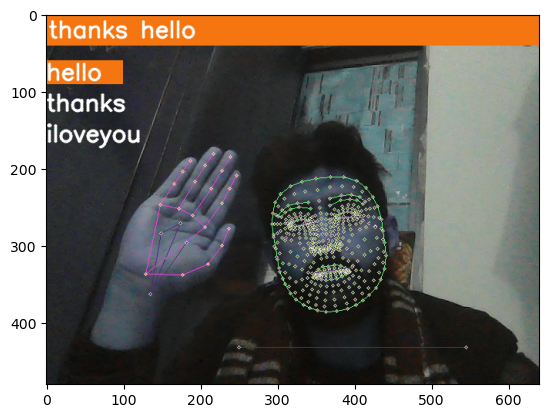

In [151]:
plt.figure()
plt.imshow(prob_viz(res, actions, image, colors))

In [46]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 44ms/step
thanks
<class 'media

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==========

In [135]:
cap.release()
cv2.destroyAllWindows()